# 206.2. Deblender Footprints

<div style="max-width:300px; float: left; margin-right: 1em">

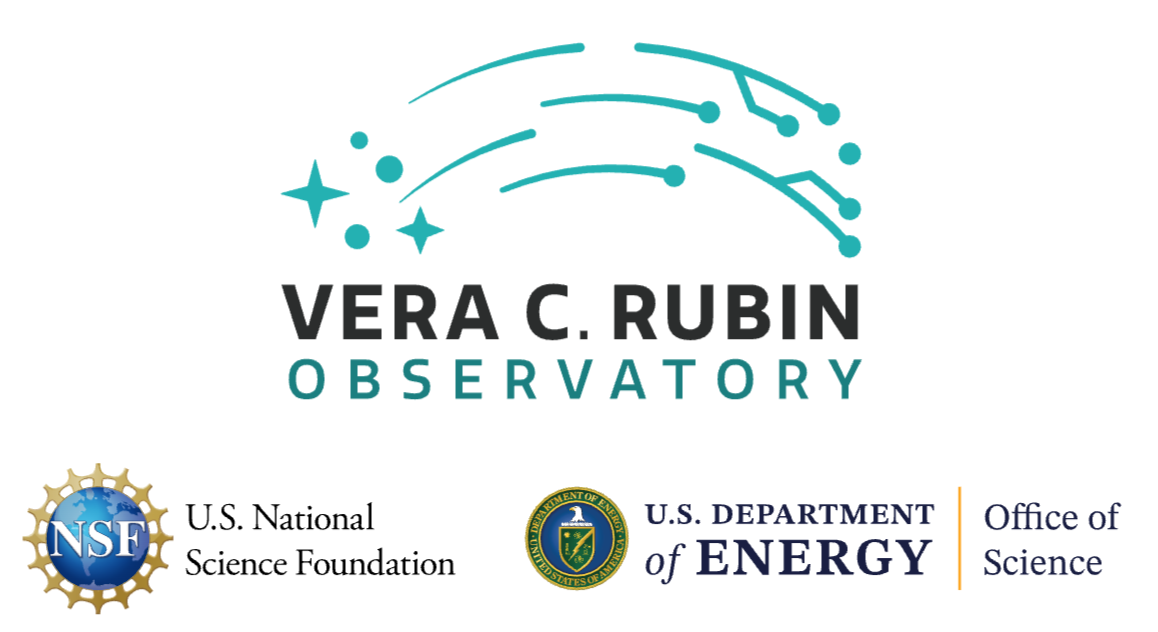


</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: DP1 <br>
Container Size: Large <br>
LSST Science Pipelines version: Weekly 29.2.0 <br>
Last verified to run: 2025-10-06 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** This notebook demonstrates how to reconstruct the footprint of blends that are separated by the deblender.

**LSST data products:** `Object` table, `deep_coadd`, `object_scarlet_models`

**Packages:** `lsst.daf.butler`, `lsst.afw`, `lsst.rsp`, `lsst.scarlet.lite`, `lsst.meas.extensions.scarlet`

**Credit:** Originally developed by Christina Williams and the Rubin Community Science team. This notebook is partly based on DP0.2 notebook 10 on deblender data products, materials developed by Fred Moolecamp, and benefited from helpful discussions with him. Thanks to Grant Merz for raising questions about reconstructing footprints using DP1 in the Rubin Community Forum. These packages are based on <a href="https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract">Melchior et al. 2018</a>, and the <a href="https://pmelchior.github.io/scarlet/">Scarlet software</a> written by Peter Melchior and Fred Moolekamp. Further documentation on Scarlet is available at that site. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.


## 1. Introduction

This notebook demonstrates how to reconstruct per-pixel models of objects that are deblended by the LSST Science Pipeline when building the `Object` table.

To measure the photometry of objects in `deep_coadd` images, the LSST Science Pipeline uses the multi-band deblending scarlet algorithm [Melchior et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26C....24..129M/abstract) implemented with optimizations for LSST data in [Scarlet Lite](https://github.com/lsst/scarlet_lite). The core algorithm models objects in a blend as a collection of components that have the same spectrum in each pixel of their morphology, assuming that flux monotonically decreases from the peak (maximum pixel value) of the component.

This tutorial will begin with the coordinates of an object of interest and show how to obtain its model and the model of the other sources that are extracted from the same blend.

**Note**: There have been updates to the deblending implementation since DP1 so _expect the API to be slightly different (improved) in future data releases_, including having more information available to understand how blended an object is with its neighbors and useful cuts to remove potentially more difficult blends from analysis.

**References:** 
- A general discussion of blending impacts to LSST can be found in this article titled "<a href="https://lss.fnal.gov/archive/2021/pub/fermilab-pub-21-598-ppd.pdf">The challenge of blending in large sky surveys</a>" by Melchior et al. 2021. 
- Some more in-depth presentations on the deblending implementation in the LSST Science Pipeline are available from recorded talks during the Rubin Project and Community Workshop 2022's session on "<a href="https://project.lsst.org/meetings/rubin2022/agenda/deblending-plans-and-challenges">Deblending Plans and Challenges</a>". 
- Further information about the available deblending flags, and the processes that produce the deblender data products discussed in this tutorial
can be found in this <a href="https://pipelines.lsst.io/modules/lsst.pipe.tasks/deblending-flags-overview.html">overview of the deblending flags</a>.


**Related tutorials:**
A notebook introducing the deblender data products stored in the `Object` table is available as 206.1 Introduction to deblender outputs. 


### 1.1. Import packages

`lsst.afw.image` provides access to some of the extended products created by the deblender pipeline. The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler. Finally, `lsst.scarlet.lite` and `lsst.meas.extensions.scarlet` are two packages containing the scarlet software infrastructure, to enable displaying and analyzing deblended models and object footprints. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler

from lsst.rsp import get_tap_service
import lsst.geom as geom

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure

import lsst.scarlet.lite as sl
import lsst.meas.extensions.scarlet as mes


### 1.2. Define parameters and functions


Set the backend for afwDisplay to matplotlib.

In [ ]:
afwDisplay.setDefaultBackend('matplotlib')

Get an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Instantiate the Butler.

In [ ]:
butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

## 2. Identify a blend¶

This first section will identify a blend in DP1, query the `Object` table for the deblended child objects, and visualize the blend.


### 2.1. Query for deblended objects

Re-use a known blend whose `parentObjectId` 611256447031839519. The blend is near the center of the ECDFS field. Define the center coordinates to enable a faster search for all objects that were deblended from this parent.

In [ ]:
parentId = 611256447031839519

ra = 53.2
dec = -27.5


Use TAP to query for all children that were deblended from the selected parent.

In [ ]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, parentObjectId, footprintArea " + \
        "FROM dp1.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", .1)) = 1 " + \
        "AND parentObjectId = " + str(parentId)


Execute the query and check that it completes.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Save the query results as a table called `children`. There are 9 deblended sources from this parent.

In [ ]:
assert job.phase == 'COMPLETED'
children = job.fetch_result().to_table()
children

### 2.2. Visualize the blend


To visualize the blend, first define a function to generate an image cutout. 

In [ ]:
def cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    print("bbox = ", bbox, "xy = ", xy, "cutoutSize = ", cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)
    tract = tractInfo.getId()

    parameters = {'bbox': bbox}

    query = """band.name = '{}' AND patch = {} AND tract = {}
        """.format(band, patch, tract)
    print(query)

    dataset_refs = butler.query_datasets("deep_coadd", where=query)

    cutout_image = butler.get(dataset_refs[0], parameters=parameters)

    return cutout_image

Make a cutout of the `deep_coadd` imaging, using the `cutout_coadd` function to visualize blend and its child objects. Set the size of the cutout to be 5x the square root of the total `footprintArea` of the blend.
 

In [ ]:
total_footprint_area = np.sum(children['footprintArea'])

cutout = cutout_coadd(butler, children['coord_ra'][0],
                      children['coord_dec'][0],
                      band='i', datasetType='deepCoadd',
                      cutoutSideLength=5.0
                      * np.sqrt(total_footprint_area))

Display the cutout, and overplot red circles to identify the child objects that were deblended. 

In [ ]:
fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout.image)
with display.Buffering():
    for ci in range(len(children)):
        display.dot('o', children['x'][ci], children['y'][ci],
                    size=10, ctype=afwDisplay.RED)
plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

> **Figure 1:** The cutout of the i-band `deep_coadd` image displayed in greyscale, with red circles marking the deblended children. 


## 3. Blend and object models

Scarlet Lite uses the multi-wavelength images to identify peaks. The scarlet models produced during deblending are available as a data product via the `object_scarlet_model` catalog. This contains all of the information needed to reconstruct the multi-band model for each source, including obtaining the flux re-distributed model. 

Below, find the `object_scarlet_model` data product in the butler by searching for all dataset types with the word "scarlet" in the name. 

In [ ]:
registry = butler.registry

for dt in sorted(registry.queryDatasetTypes('*scarlet*')):
    print(dt)


Next, use the butler to find the `deep_coadd` image that overlaps the coordinates of the blend using the location of one child object. The butler query returns a list of dataset references for images that overlap. 

In [ ]:
query = """band.name = '{}' AND patch.region OVERLAPS POINT({}, {})
        """.format('i', children['coord_ra'][0], children['coord_dec'][0])
print(query)


Pick the first dataset reference (identified with index 0) and save its dataId. 

In [ ]:
dataset_refs = butler.query_datasets("deep_coadd", where=query)
dataId = dataset_refs[0].dataId


### 3.1. Load the blend model

Use the butler to retrieve the `object_scarlet_models` data product that corresponds to the image with this dataId. `patch` and `tract` can also be used directly as keywords instead of `dataId`.

In [ ]:
modelData = butler.get("object_scarlet_models", dataId=dataId)

The LSST science pipelines use persistable `dataclass` objects as intermediaries between the storage containers and python classes. In the case of Scarlet Lite blends, this is the `ScarletBlendData` class. Some attributes of the blend model can be retrieved from `modelData`.

In order to reconstruct the blend, the model PSF from the deconvolved model space is also required. The model PSF is the same for all blends, so extract that here.

Also extract the set of blends associated with this `parentObjectId`.


In [ ]:
model_psf = modelData.psf
blend_data = modelData.blends[parentId]

### 3.2 Convert to a usable blend instance

First, define a monkey patch that temporarily updates the `minimal_data_to_blend` LSST pipeline class in order to fix an issue with DP1 (temporarily while running this notebook). Once the fix enters the pipeline version in use, the following cell defining the monkey patch can simply be deleted without additional alteration to the notebook. The following cells will use this monkey patch version to load the blend.


In [ ]:
from numpy.typing import DTypeLike
from lsst.scarlet.lite import Box, Blend, Observation


def minimal_data_to_blend(cls, model_psf: np.ndarray, dtype: DTypeLike) -> Blend:

    """Convert the storage data model into a scarlet lite blend

    Parameters
    ----------
    model_psf:
        PSF in model space (usually a nyquist sampled circular Gaussian).
    dtype:
        The data type of the model that is generated.

    Returns
    -------
    blend:
        A scarlet blend model extracted from persisted data.
    """
    model_box = Box(cls.shape, origin=cls.origin)
    observation = Observation.empty(
        bands=cls.bands,
        psfs=cls.psf,
        model_psf=model_psf,
        bbox=model_box,
        dtype=dtype,
    )
    return cls.to_blend(observation)


import lsst.scarlet as scarlet
scarlet.lite.io.ScarletBlendData.minimal_data_to_blend = minimal_data_to_blend

Now recreate the blend model using the monkey patch.

In [ ]:
blend = blend_data.minimal_data_to_blend(model_psf[None, :, :], dtype=np.float32)

### 3.3. Plot the blend model

The LSST pipelines do not necessarily process in order of wavelength, i.e. ugrizy. Check how many bands exist over the blend of interest, and what order they are in.

In [ ]:
observed_bands = blend_data.bands
print(observed_bands)

Printing `blend_data.bands` shows that this patch and tract in ECDFS was observed with all 6 bands but they are not in the order of increasing wavelength. To ensure that expected order, specify `model[tuple("ugrizy")]` when retrieving the blend model to display the image with the expected color assignment in the cell below. If fewer bands of coverage exist (as is the case for some DP1 fields), simply replace this by the combination of observed bands, e.g. `tuple("griz")`. For this example, select only 4 filters and exclude the `u` and `y` bands, which add unnecessary noise that makes it difficult to see the underlying objects.

**Note:** this will change the order of the bands displayed in this instance of the the model but **not** in the `blend` instance. After DP1, a change is planned so that `blend = blend[display_bands]` can be used to reorganize all of the models so that they are displayed in a new order.

In [ ]:
display_bands = tuple("griz")
model = blend.get_model(convolve=True)[display_bands]

Finally, plot a color image of the blend model. Use the `AsinhMapping` to normalize: the asinh stretch preserves colors independent of brightness (for more information see <a href="https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L">Lupton et al. 2024</a>). By default, Scarlet Lite will map the input filters into an red green blue (RGB) scaling where shorter wavelength filters map to blue and longer wavelength map to red (and assumes the order in the model is set as such, defined in the previous cell). This relative weighting between filters to RGB can be altered with the `channel_map` keyword to `img_to_rgb` (see documentation <a href="https://pmelchior.github.io/scarlet/tutorials/display.html">here</a>).

In [ ]:
norm = sl.display.AsinhMapping(minimum=0, stretch=10, Q=10)
rgb = sl.display.img_to_rgb(model.data, norm=norm)
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.show()

> **Figure 2:** A `griz` RGB color image of the blend model. By default, Scarlet Lite maps the filters into an RGB scaling where shorter wavelength filters contribute to the blue color and longer wavelength filters contribute to red.

## 4. Compare to observation

This section will make visual comparisons between the blend model and the observed data, and demonstrate some of the Scarlet Lite functionality. To load the observation, the following information is required: 1) the `tract` and `patch` that defines the region of the sky imaged in the `deep_coadd`; 2) the bounding box of the parent, which allows extraction a smaller region from the full `deep_coadd`; and 3) the bands desired for display.

**Note:** the bands need to be in the same order as the `blend` band order in DP1.




The tract and patch were already identified as part of the deep_coadd dataId in Section 3. Here, all that is needed is extract the bounding box of the `blend` and convert it from a `lsst.scarlet.lite.Box` to an `lsst.afw.Box2I`

In the cell below, build the bounding box of the parent (this allows extraction of a smaller region from the full coadd).


In [ ]:
box = sl.Box(blend_data.shape, blend_data.origin)
bbox = mes.utils.scarletBoxToBBox(box)

Load the subset of the image that overlaps with the blend, then use the `blend_data` and the `observation` to create a full `Blend`. All of the model information is the same as the information from the `Blend` that we created earlier. Here, attach real `Observation` data as opposed to an empty `Observation` (as was done in Section 3.2). Notice that the `observed_bands` are passed here, not the `display_bands`, as these bands must match the order of the bands in the `blend`.

Model residuals compared to the observations are of interest for exploring how well the blend model matches the data. To do this, first load a multiband exposure as the input observation. Use the `patch` and `tract` to reconstruct the multiband `deep_coadd` for this blend.


In [ ]:
mCoadd = MultibandExposure.fromButler(butler, observed_bands,
                                      "deep_coadd", tract=dataId['tract'], patch=dataId['patch'],
                                      parameters={"bbox": bbox})

observation = mes.utils.buildObservation(modelPsf=model_psf,
                                         psfCenter=bbox.getCenter(),
                                         mExposure=mCoadd,
                                         )

blend = blend_data.to_blend(observation)

Like the `Blend` model, the `Observation` has bands that are not ordered by wavelength. Use the same method to re-arrange the bands and display the observed image using the same band order as the original image.

In [ ]:
norm = sl.display.AsinhMapping(minimum=0, stretch=5, Q=10)
images = observation.images[display_bands]
rgb = sl.display.img_to_rgb(images, norm=norm)
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.show()

> **Figure 3:** A `griz` RGB color image of the observed image. By default, Scarlet Lite maps the filters into an RGB scaling where shorter wavelength filters contribute to the blue color and longer wavelength filters contribute to red.


### 4.1 Display the residuals

Now display the scene. The function scarlet `show_scene` will include the model footprints, the model rendered (i.e. convolved with the PSF), the locations on the observed multiband image, and residuals between the real image and the model. Model residuals compared to the observations are of interest for exploring how well the blend model matches the data. 

To normalize the image, use the Lupton RGB `AsinhMapping`, which preserves the observed colors.

**Note:** You'll notice that the colors match the processed color order `observed_bands`, not the correct band order. In the future passing `blend[display_bands]` should display everything in the correct order.


In [ ]:
norm = sl.display.AsinhMapping(minimum=0, stretch=10, Q=10)

sl.display.show_scene(
    blend,
    norm=norm,
    show_model=True,
    show_rendered=True,
    show_observed=True,
    show_residual=True,
    linear=False,
    add_boxes=True,
    add_labels=True,
    figsize=(10, 7),
)

plt.show()

> **Figure 4:** Visualization of the model generated by Scarlet Lite, with x and y axes indicating pixel number from the patch/tract. The panels show the blend model (not PSF-convolved; top left), the blend model rendered (PSF-convolved; top right), the observation (bottom left) and the residual image (observation - model rendered; bottom right). All deblended sources are identified with white boxes and a number indicating its ID within the set of deblended objects.

Finally, use the `show_sources` function to display each individual deblended object's model (left), its location in the image (middle), and its broad-band spectrum (right). Note that since this function takes `blend` as input, whose filter order we did not change. The band order used in the RGB and for the spectrum panel is thus the same as `observed_bands`.

**Note:** Due to a bug in the DP1 code there is a bug that incorrectly displays the rendered (PSF convolved) model of each source. In the future passing `show_rendered=True` will also display the rendered version of the source.

In [ ]:
sl.display.show_sources(blend,
                        norm=norm,
                        show_observed=True,
                        add_boxes=True
                        )
plt.show()

> **Figure 5:** Visualization of the individual deblended sources (top to bottom show ID 0 to 8). For each source, left panel shows the PSF-deconvolved model footprint (where the color scale corresponds to the weighted RGB color), middle panel shows the observation of the blend with the source identified by a white box, and right panel shows the flux in each band. The bands are shown all 6 LSST filters, and are in observation order, i.e. `observed_bands`.

## 5. Analyzing a single object

Individual objects can be inspected. Here, select the second brightest object in the blend (listed as Source 1 in the output in Section 4.1) and access its `objectId`.

In [ ]:
object1 = blend.sources[1]
print(object1.record_id)


### 5.2 Creating the flux re-distributed models

In the LSST science pipeline, measurements are not made on the Scarlet models directly. Imperfections in the PSF measurement and deviations of bright galaxies from a simple two-component monotonic morphology solution (see Melchior paper cited above) result in improper measurements. Instead, a deblending algorithm based on the SDSS deblender is employed, using the scarlet models as templates, and flux is re-distributed from the input image based on the ratio of values for overlapping templates in an image.

In [ ]:
blend.conserve_flux()

### 5.3 Display the source model

Three different models for the object are available for inspection. 1) The deconvolved scarlet model; 2) the convolution of the scarlet model with the difference kernel; and 3) the flux-redistributed model that the science pipelines use for measurement. The section demonstrates how to plot these three different models for source 1 in the blend.

First, extract the deconvolved model from the object. The output is a Scarlet Lite image.

In [ ]:
source_model = object1.get_model()

Next, project the model into a box large enough to fit the convolved model.

In [ ]:
psf_radius = int((np.max(blend.observation.psfs.shape)+1)//2)
enlarged_box = source_model.bbox.grow(psf_radius)
convolved_model = source_model.copy().project(bbox=enlarged_box)

Finally, plot the three models for the object for inspection.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

extent = sl.display.get_extent(object1.bbox)
rgb = sl.display.img_to_rgb(source_model[display_bands], norm=norm)
ax[0].imshow(rgb, origin='lower', extent=extent)
ax[0].set_title("Deconvolved Model")

convolved_model = blend.observation.convolve(convolved_model)
extent = sl.display.get_extent(enlarged_box)
rgb = sl.display.img_to_rgb(convolved_model[display_bands], norm=norm)
ax[1].imshow(rgb, origin='lower', extent=extent)
ax[1].set_title("Convolved Model")

flux_model = object1.flux_weighted_image
extent = sl.display.get_extent(flux_model.bbox)
rgb = sl.display.img_to_rgb(flux_model[display_bands], norm=norm)
ax[2].imshow(rgb, origin='lower', extent=extent)
ax[2].set_title("Flux Re-distributed Model")

plt.show()

> **Figure 6:** Visualization of deblended source 1. Left panel shows the PSF-deconvolved model footprint (where the color scale corresponds to the weighted RGB color), middle panel shows the convolution of the scarlet model with the difference kernel and right panel shows the flux-redistributed model that the science pipelines use for measurements.